In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)

heart_df = pd.read_csv('/content/drive/MyDrive/datasets/heart_disease_prediction.csv')


heart_df.isnull().sum()

,0
gender,0
age,0
educationLevel,105
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50


In [ ]:
desc = heart_df.describe().T
desc["std_err"] = desc["std"] / np.sqrt(heart_df.shape[0])
desc["Degree of freedom"] = heart_df.shape[0] - 1
print(desc)

                  count        mean        std     min     25%    50%  \
gender           4238.0    0.429212   0.495022    0.00    0.00    0.0   
age              4238.0   49.584946   8.572160   32.00   42.00   49.0   
educationLevel   4133.0    1.978950   1.019791    1.00    1.00    2.0   
currentSmoker    4238.0    0.494101   0.500024    0.00    0.00    0.0   
cigsPerDay       4209.0    9.003089  11.920094    0.00    0.00    0.0   
BPMeds           4185.0    0.029630   0.169584    0.00    0.00    0.0   
prevalentStroke  4238.0    0.005899   0.076587    0.00    0.00    0.0   
prevalentHyp     4238.0    0.310524   0.462763    0.00    0.00    0.0   
diabetes         4238.0    0.025720   0.158316    0.00    0.00    0.0   
totChol          4188.0  236.721585  44.590334  107.00  206.00  234.0   
sysBP            4238.0  132.352407  22.038097   83.50  117.00  128.0   
diaBP            4238.0   82.893464  11.910850   48.00   75.00   82.0   
BMI              4219.0   25.802008   4.080111   15

In [ ]:
heart_df.head()

,gender,age,educationLevel,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,tenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
heart_df.duplicated().any()

np.False_

In [ ]:
# Fill missing categorical values
heart_df.drop(columns=['educationLevel'], inplace=True)
heart_df['BPMeds'] = heart_df['BPMeds'].fillna(0)

# Fill cigsPerDay depending on currentSmoker
heart_df.loc[(heart_df['currentSmoker'] == 0) & (heart_df['cigsPerDay'].isnull()), 'cigsPerDay'] = 0
heart_df['cigsPerDay'] = heart_df['cigsPerDay'].fillna(heart_df['cigsPerDay'].median())

# Fill missing continuous values with median
for col in ['totChol', 'BMI', 'heartRate', 'glucose']:
    heart_df[col] = heart_df[col].fillna(heart_df[col].median())


heart_df.isnull().sum()

,0
gender,0
age,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0
sysBP,0


[0.01863794 0.13645638 0.01446986 0.05458027 0.00885441 0.00602421
 0.02411387 0.00938522 0.11863629 0.13302251 0.12183462 0.11913087
 0.11349899 0.12135455]


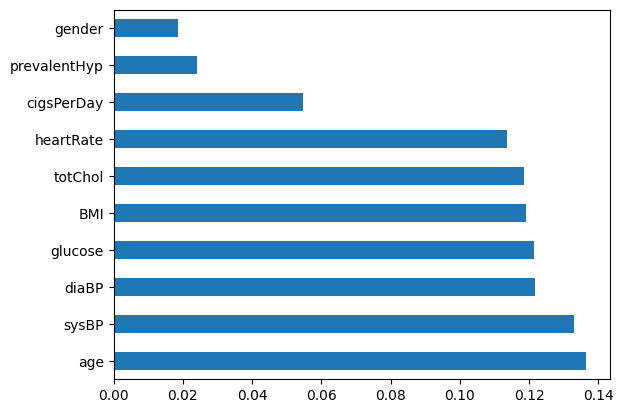

In [ ]:
# Separate features and target
X = heart_df.drop('tenYearCHD', axis=1)
y = heart_df['tenYearCHD']

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


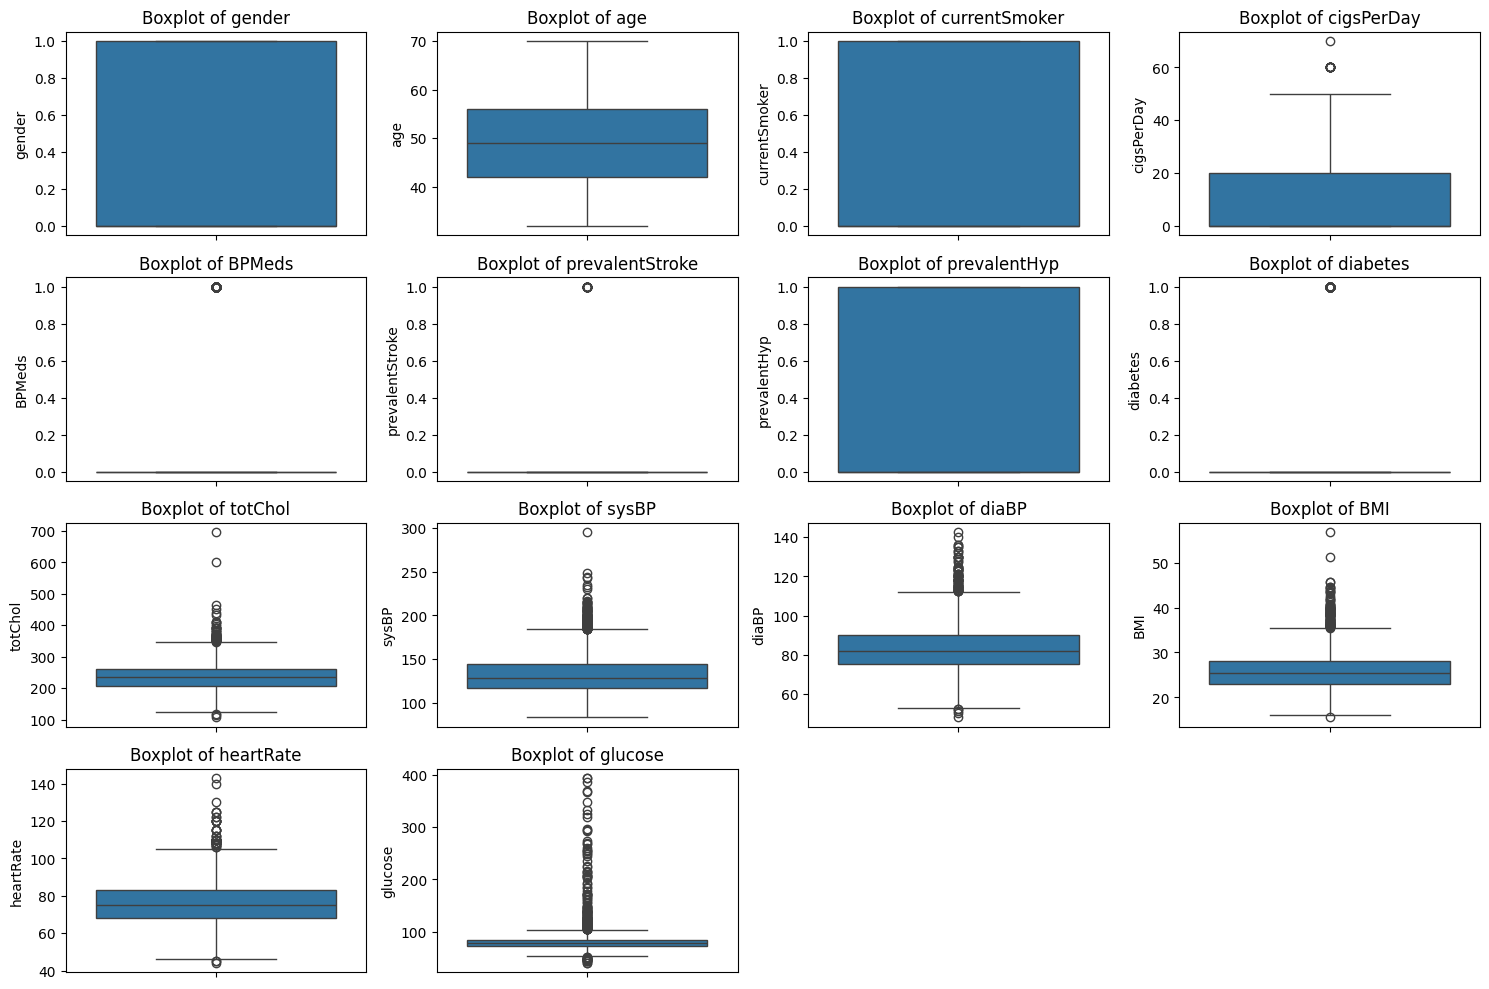

In [ ]:
# Visualize outliers
numerical_cols = heart_df.select_dtypes(include='number').columns.drop('tenYearCHD')

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=heart_df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Exclude target column from IQR computation
features_only = heart_df.drop(columns='tenYearCHD')

# Store original number of rows
original_count = heart_df.shape[0]

# Compute IQR
Q1 = features_only.quantile(0.25)
Q3 = features_only.quantile(0.75)
IQR = Q3 - Q1

# Create mask for non-outliers
mask = ~((features_only < (Q1 - 1.5 * IQR)) | (features_only > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter the dataframe
heart_df = heart_df[mask]

# Store new number of rows
filtered_count = heart_df.shape[0]

# Print how many records were dropped
print(f"Records before outlier removal: {original_count}")
print(f"Records after outlier removal: {filtered_count}")
print(f"Number of records dropped: {original_count - filtered_count}")


Records before outlier removal: 4238
Records after outlier removal: 3545
Number of records dropped: 693


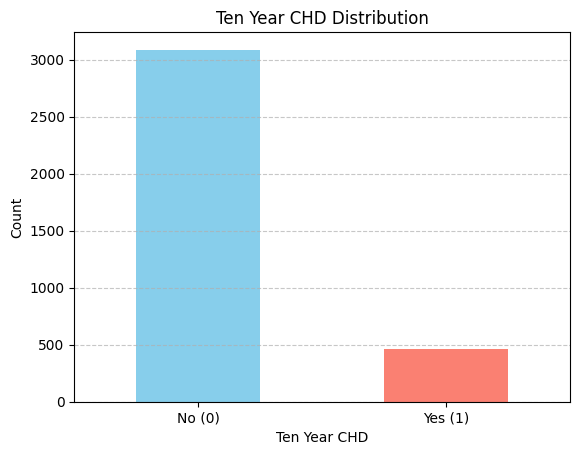

In [ ]:
heart_df['tenYearCHD'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Ten Year CHD Distribution')
plt.xlabel('Ten Year CHD')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

tenYearCHD
0    3086
1    3086
Name: count, dtype: int64


/tmp/ipython-input-10-2940654172.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette='Set2')


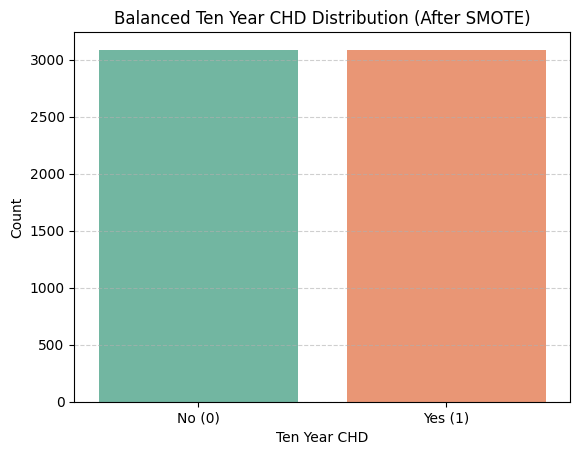

In [ ]:
# Separate features and target
X = heart_df.drop('tenYearCHD', axis=1)
y = heart_df['tenYearCHD']

# Initialize SMOTE
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print(y_resampled.value_counts())

# Plot the class distribution after SMOTE
sns.countplot(x=y_resampled, palette='Set2')
plt.title('Balanced Ten Year CHD Distribution (After SMOTE)')
plt.xlabel('Ten Year CHD')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No (0)', 'Yes (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Use selected features only
selected_features = ['heartRate', 'totChol', 'BMI', 'glucose', 'diaBP', 'sysBP', 'age']
X_selected = X_resampled[selected_features]

# Split data into 10% holdout and 90% temp
X_temp, X_holdout, y_temp, y_holdout = train_test_split(
    X_selected, y_resampled, test_size=0.10, random_state=42, stratify=y_resampled
)

# Split 90% temp into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp
)

# Print split sizes
print("Training size:", X_train.shape[0])
print("Testing size:", X_test.shape[0])
print("Holdout size:", X_holdout.shape[0])

Training size: 4443
Testing size: 1111
Holdout size: 618



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       556
           1       0.65      0.65      0.65       555

    accuracy                           0.65      1111
   macro avg       0.65      0.65      0.65      1111
weighted avg       0.65      0.65      0.65      1111


=== Accuracy Score ===
0.6508

=== Precision ===
0.6499

=== Recall ===
0.6523

=== F1 Score ===
0.6511


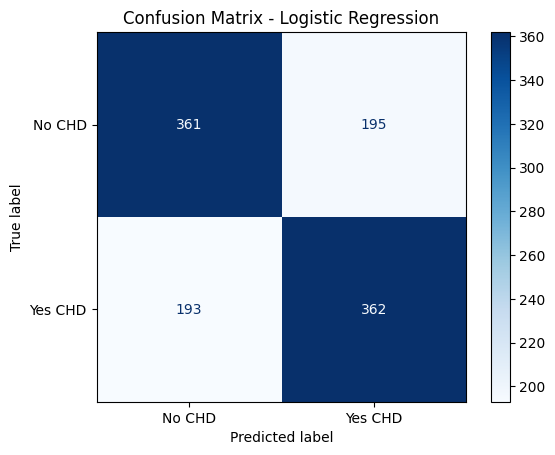

     Feature  Coefficient (log-odds)  Odds Ratio
0  heartRate               -0.001117    0.998883
1    totChol                0.000089    1.000089
2        BMI                0.007564    1.007593
3    glucose               -0.011616    0.988451
4      diaBP               -0.008104    0.991929
5      sysBP                0.019664    1.019858
6        age                0.060712    1.062593
[[361 195]
 [193 362]]


In [ ]:
# Initialize and train the model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Accuracy Score ===")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\n=== Precision ===")
print(f"{precision_score(y_test, y_pred):.4f}")

print("\n=== Recall ===")
print(f"{recall_score(y_test, y_pred):.4f}")

print("\n=== F1 Score ===")
print(f"{f1_score(y_test, y_pred):.4f}")

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No CHD", "Yes CHD"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

# Get coefficients
coef_df = pd.DataFrame({
    'Feature': X_selected.columns,
    'Coefficient (log-odds)': model.coef_[0],
    'Odds Ratio': np.exp(model.coef_[0])
})
print(coef_df)

print(cm)


=== Holdout Evaluation ===
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       309
           1       0.67      0.64      0.65       309

    accuracy                           0.66       618
   macro avg       0.66      0.66      0.66       618
weighted avg       0.66      0.66      0.66       618


=== Accuracy Score ===
0.6586

=== Precision ===
0.6655

=== Recall ===
0.6375

=== F1 Score ===
0.6512


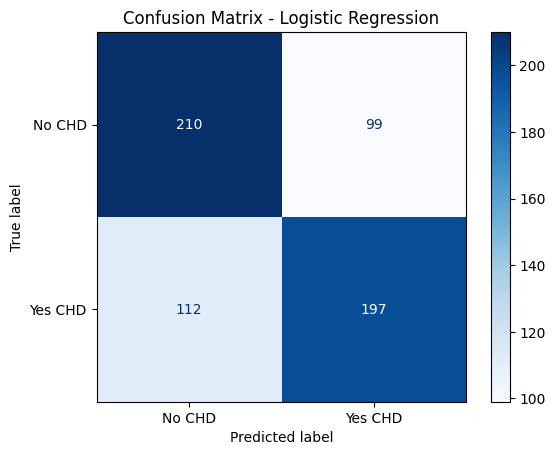

[[210  99]
 [112 197]]


In [ ]:
y_holdout_pred = model.predict(X_holdout)

print("=== Holdout Evaluation ===")
print(classification_report(y_holdout, y_holdout_pred))

print("\n=== Accuracy Score ===")
print(f"{accuracy_score(y_holdout, y_holdout_pred):.4f}")

print("\n=== Precision ===")
print(f"{precision_score(y_holdout, y_holdout_pred):.4f}")

print("\n=== Recall ===")
print(f"{recall_score(y_holdout, y_holdout_pred):.4f}")

print("\n=== F1 Score ===")
print(f"{f1_score(y_holdout, y_holdout_pred):.4f}")

# Confusion matrix plot
cm = confusion_matrix(y_holdout, y_holdout_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No CHD", "Yes CHD"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

print(cm)
